[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 832
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 13
[LightGBM] [Info] Start training from score -0.419439
[LightGBM] [Info] Start training from score -1.909712
[LightGBM] [Info] Start training from score -2.996946
[LightGBM] [Info] Start training from score -1.934324
Model: Random Forest
              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.96      0.98      0.97     19292
     malware       0.98      0.93      0.95      6504
    phishing       0.89      0.82      0.85     18822

    accuracy                           0.96    130239
   macro avg       0.95      0.93      0.94    130239
weighted avg       0.96      0

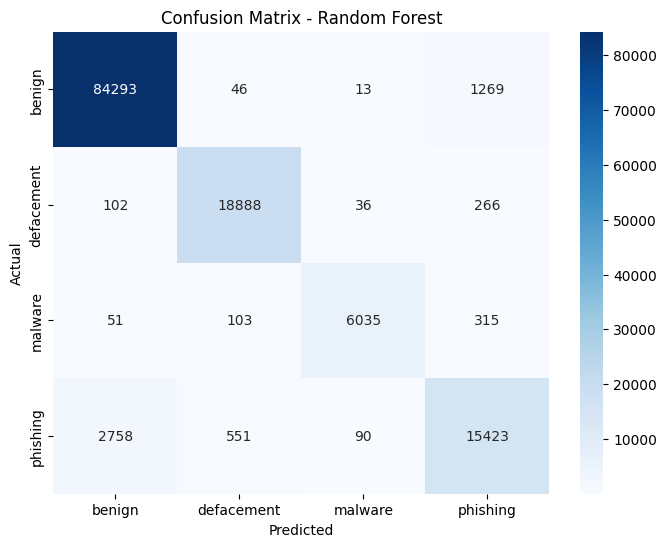

Model: LightGBM
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85621
  defacement       0.93      0.97      0.95     19292
     malware       0.95      0.87      0.91      6504
    phishing       0.89      0.79      0.84     18822

    accuracy                           0.95    130239
   macro avg       0.93      0.90      0.92    130239
weighted avg       0.95      0.95      0.95    130239

Accuracy: 0.948
F1 Score: 0.947


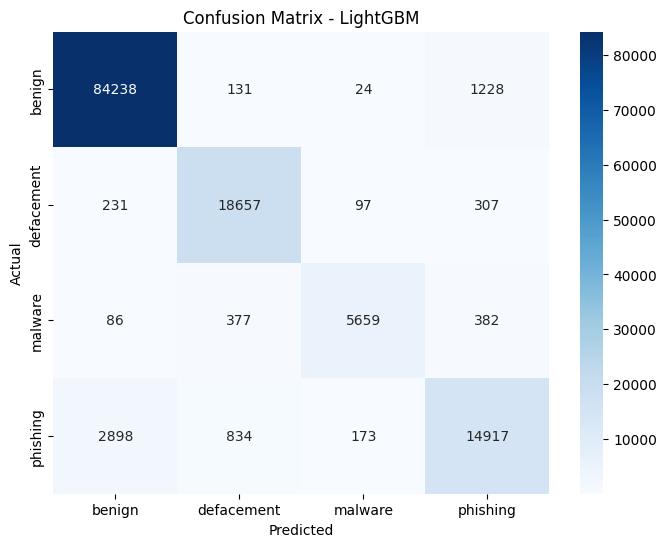

Model: XGBoost
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97     85621
  defacement       0.94      0.97      0.95     19292
     malware       0.96      0.88      0.92      6504
    phishing       0.89      0.80      0.84     18822

    accuracy                           0.95    130239
   macro avg       0.94      0.91      0.92    130239
weighted avg       0.95      0.95      0.95    130239

Accuracy: 0.951
F1 Score: 0.950


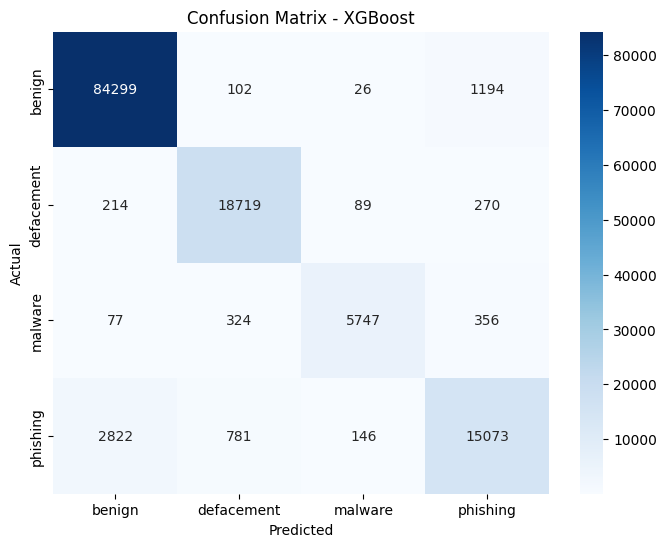

URL: www.linkedin.com/in/sukalyan-chakraborty - Prediction: phishing


In [3]:
import pandas as pd
import re
import numpy as np
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('D:/[03] Code/Quishing Project (B.Tech 2nd Year)/malicious_phish.csv')

# Feature Engineering Functions
def having_ip_address(url):
    return 1 if re.search(r'(([01]?\d{1,2}|2[0-4]\d|25[0-5])\.){3}([01]?\d{1,2}|2[0-4]\d|25[0-5])', url) else 0

def abnormal_url(url):
    hostname = urlparse(url).hostname
    return 1 if hostname and hostname in url else 0

def count_dot(url):
    return url.count('.')

def count_www(url):
    return url.count('www')

def count_atrate(url):
    return url.count('@')

def count_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

def shortening_service(url):
    return 1 if re.search(r'bit\.ly|goo\.gl|short\.ly|tinyurl', url) else 0

def url_length(url):
    return len(url)

def hostname_length(url):
    return len(urlparse(url).netloc)

def suspicious_words(url):
    return 1 if re.search(r'PayPal|login|bank|update|free', url) else 0

def digit_count(url):
    return sum(c.isdigit() for c in url)

def letter_count(url):
    return sum(c.isalpha() for c in url)

def extract_tld(url):
    try:
        return len(urlparse(url).netloc.split('.')[-1])  # Return length of the last part of the domain
    except IndexError:
        return 0

# Apply Feature Engineering
df['use_of_ip'] = df['url'].apply(having_ip_address)
df['abnormal_url'] = df['url'].apply(abnormal_url)
df['count.'] = df['url'].apply(count_dot)
df['count-www'] = df['url'].apply(count_www)
df['count@'] = df['url'].apply(count_atrate)
df['count_dir'] = df['url'].apply(count_dir)
df['short_url'] = df['url'].apply(shortening_service)
df['url_length'] = df['url'].apply(url_length)
df['hostname_length'] = df['url'].apply(hostname_length)
df['sus_url'] = df['url'].apply(suspicious_words)
df['count-digits'] = df['url'].apply(digit_count)
df['count-letters'] = df['url'].apply(letter_count)
df['tld_length'] = df['url'].apply(extract_tld)

# Drop the original 'tld' column as it was extracted
df.drop(columns=['url'], inplace=True)  # Drop URL if it's not needed for modeling

# Label Encoding for Target Variable
label_encoder = LabelEncoder()
df['type_code'] = label_encoder.fit_transform(df['type'])

# Prepare Features and Target Variable
X = df[['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
         'count_dir', 'short_url', 'url_length', 'hostname_length', 
         'sus_url', 'count-digits', 'count-letters', 'tld_length']]
y = df['type_code']

# Convert features to numeric type
X = X.astype(float)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 2. Light GBM Classifier
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)

# 3. XGBoost Classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Function to evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.3f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate all models
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_lgb, "LightGBM")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Function to predict URL type
def get_prediction_from_url(test_url):
    features_test = np.array([
        having_ip_address(test_url),
        abnormal_url(test_url),
        count_dot(test_url),
        count_www(test_url),
        count_atrate(test_url),
        count_dir(test_url),
        shortening_service(test_url),
        url_length(test_url),
        hostname_length(test_url),
        suspicious_words(test_url),
        digit_count(test_url),
        letter_count(test_url),
        extract_tld(test_url)
    ], dtype=float).reshape(1, -1)  
    pred = lgb.predict(features_test)  # Using LightGBM for prediction
    return label_encoder.inverse_transform(pred)[0]

# Test prediction
urls = ['www.linkedin.com/in/sukalyan-chakraborty']
for url in urls:
    print(f"URL: {url} - Prediction: {get_prediction_from_url(url)}")
